## Импортируем библеотеки

In [1]:
import pandas as pd
import numpy as np
import random

from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader

import scipy.signal as signal

!pip install tsmoothie
from tsmoothie.smoother import *

!pip install optuna
import optuna

clear_output()

## Выбираем на чем учить (видеокарта или процессор)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Фиксируем random seed

In [3]:
def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

In [4]:
set_random_seed(42)

## Чтение данных из файла

Подгрузка скриптов:

In [5]:
import zipfile
import os

!wget --no-check-certificate \
    "https://github.com/PolMix/temp-forecast/archive/refs/heads/main.zip" \
    -O "/tmp/data.zip"


zip_ref = zipfile.ZipFile('/tmp/data.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/content') #Extracts the files into the /tmp folder
zip_ref.close()

--2023-08-26 05:41:38--  https://github.com/PolMix/temp-forecast/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/PolMix/temp-forecast/zip/refs/heads/main [following]
--2023-08-26 05:41:38--  https://codeload.github.com/PolMix/temp-forecast/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.114.9
Connecting to codeload.github.com (codeload.github.com)|140.82.114.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/tmp/data.zip’

/tmp/data.zip           [ <=>                ]   6.00K  --.-KB/s    in 0s      

2023-08-26 05:41:39 (63.1 MB/s) - ‘/tmp/data.zip’ saved [6147]



Работа с файлом датасета:

In [6]:
filename = '288x10.csv'

In [7]:
column_names_maper = {}
column_names_maper[0] = 'time'
column_names_maper[1] = 'mode'
for i in range(2, 290):
    column_names_maper[i] = i - 1

In [9]:
heat_data = pd.read_csv(filename, sep='\t', header=None).rename(column_names_maper, axis=1)
heat_data = heat_data.drop(columns=290)
heat_data = pd.concat([heat_data.drop(columns='mode'), pd.get_dummies(heat_data['mode'], prefix='mode')], axis=1)
heat_data = heat_data.drop(columns=['mode_1', 'time'])

In [10]:
heat_data.sample()

,1,2,3,4,5,6,7,8,9,10,...,281,282,283,284,285,286,287,288,mode_2,mode_3
2483,45.037,43.433,43.337,44.142,44.446,43.594,41.826,46.386,44.192,42.753,...,45.138,40.7,42.89,44.906,42.789,42.708,44.953,44.797,0,0


In [11]:
heat_data.shape

(11100, 290)

## Визуализация данных

/content/temp-forecast-main/script


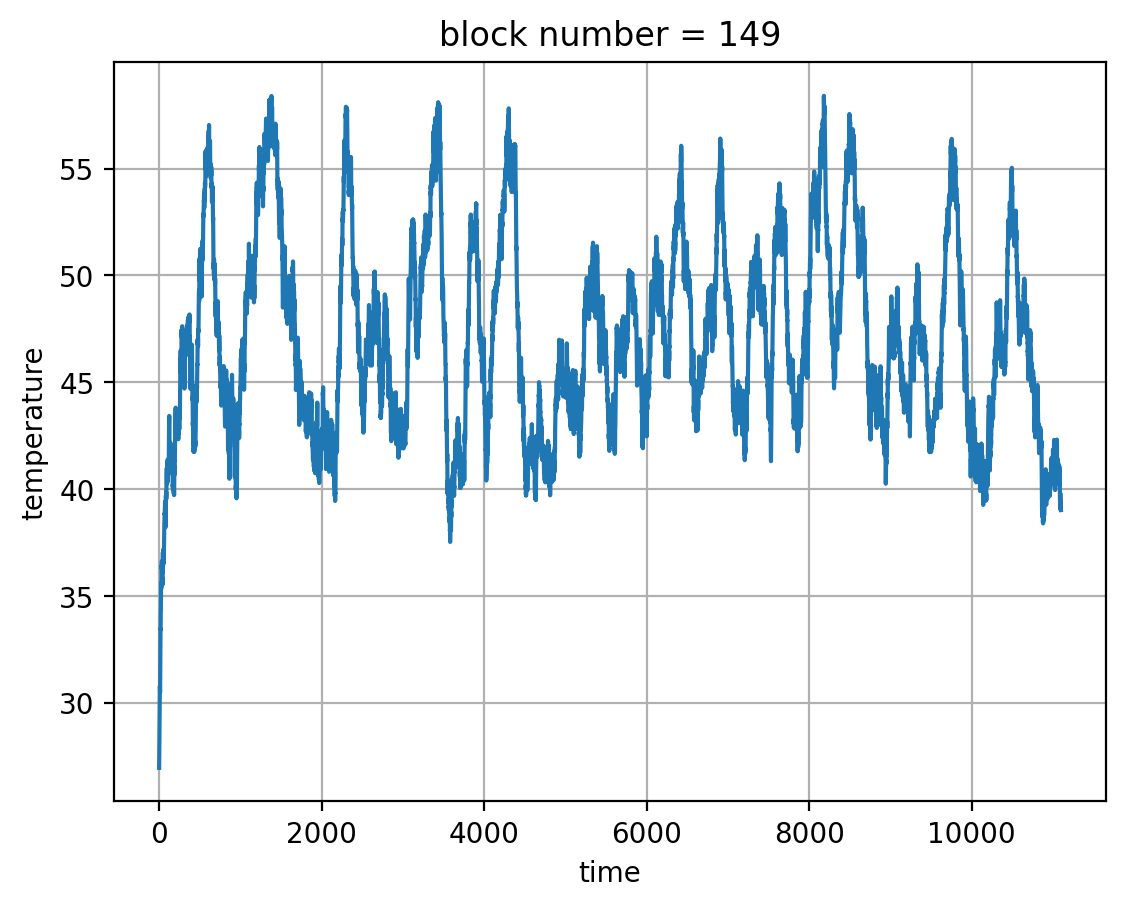

In [12]:
%cd /content/temp-forecast-main/script
from plotting import plot_dataset

plot_dataset(heat_data=heat_data, block_number=149) # here you can set block number which temperature-time dependence you want to visualise

## Сглаживание данных (убирает пики охлаждения, поэтому код закомментирован)

Функция для отрисовки двух временных рядов на одном полотне для визуального сравнения:

In [ ]:
# def plot_smoothed_data(heat_data, heat_data_smoothed, block_number):
#     clear_output()
#     plt.figure(figsize=(5, 5), dpi=150)
#     plt.plot(range(1, len(heat_data) + 1), heat_data.iloc[:, block_number], label='original', color='black')
#     plt.plot(range(1, len(heat_data) + 1), heat_data_smoothed[:, block_number], label='smoothed', color='red')
#     plt.ylabel('Temperature')
#     plt.xlabel('Time')
#     plt.title(f'block_number = {block_number}')
#     plt.legend()
#     plt.grid()
#     plt.show()

### Сглаживание фильтром Савицкого-Голея

Будем сравнивать сглаженный и исходный варианты:

In [ ]:
# heat_data_no_filter = heat_data.copy()

Метод, осуществляющий сглаживание:

In [ ]:
# heat_data_smoothed = signal.savgol_filter(x=heat_data.iloc[:, :-2], window_length=151, polyorder=3, axis=1)

Визуализация результата сглаживания данных:

In [ ]:
# block_number = 42
# plot_smoothed_data(heat_data, heat_data_smoothed, block_number)

### Фильтры библиотки `tsmoothie`

Почитать про фильтры для сглаживания: https://github.com/cerlymarco/tsmoothie/blob/master/README.md

In [ ]:
#ExponentialSmoother?

In [ ]:
'''heat_data_smoothed = heat_data.copy()

#smoother = ConvolutionSmoother(window_len=12, window_type='ones')
smoother = ExponentialSmoother(window_len=20, alpha=0.25)
smoother.smooth(heat_data_smoothed.iloc[:, :-2].to_numpy())
heat_data_smoothed = smoother.smooth_data
names = ['Smoothed data', 'Initial data']
plot_losses(heat_data_smoothed[:3900, 0], heat_data_no_filter.iloc[50:3900, 0].to_numpy(), names=names)'''

"heat_data_smoothed = heat_data.copy()\n\n#smoother = ConvolutionSmoother(window_len=12, window_type='ones')\nsmoother = ExponentialSmoother(window_len=20, alpha=0.25)\nsmoother.smooth(heat_data_smoothed.iloc[:, :-2].to_numpy())\nheat_data_smoothed = smoother.smooth_data\nnames = ['Smoothed data', 'Initial data']\nplot_losses(heat_data_smoothed[:3900, 0], heat_data_no_filter.iloc[50:3900, 0].to_numpy(), names=names)"

#### Дообработка датасета после фильтрации

Конвертируем np-массив данных в pd-таблицу и добавляем в эту таблицу информацию о режимах работы:

In [ ]:
'''heat_data = heat_data_smoothed
heat_data = pd.DataFrame(heat_data)
heat_data = pd.concat([heat_data, heat_data_no_filter.iloc[:, -2:]], axis=1)
heat_data.sample(5)'''

'heat_data = heat_data_smoothed\nheat_data = pd.DataFrame(heat_data)\nheat_data = pd.concat([heat_data, heat_data_no_filter.iloc[:, -2:]], axis=1)\nheat_data.sample(5)'

## Удаляем стартовые измерения (для улучшения качества предсказания)

Дополнительно удалим первые 50 измерений. Это нужно, чтобы избавиться от длинного "хвоста" температур от 30 до 40 градусов, которые сильно влияют на нормировку всего датасета.

Пояснение: если оставить этот хвост, то при нормировке датасета этот хвост будет занимать 80% всех нормированных значений (от 0 до 0.8), а полезная часть будет занимать значения от 0.8 до 1.0, что негативно влияет на качество обучения и предсказаний

In [13]:
heat_data = heat_data.iloc[50:, :]

Если хотите обучать модель только для нескольких блоков, то разблокируйте код ниже:

In [14]:
#heat_data = heat_data.drop(columns=[index for index in range(2, 289)])

In [15]:
heat_data.head(2)

,1,2,3,4,5,6,7,8,9,10,...,281,282,283,284,285,286,287,288,mode_2,mode_3
50,39.656,36.365,38.419,41.962,36.968,38.392,38.505,39.506,41.602,39.120,...,37.016,35.483,36.760,34.045,38.129,38.057,36.553,36.843,0,0
51,40.228,36.298,38.319,41.911,37.159,38.943,38.430,39.575,41.973,39.294,...,36.907,35.546,36.634,34.142,38.445,37.916,37.107,36.779,0,0


In [16]:
heat_data.shape

(11050, 290)

## Создаем dataset и dataloader

In [17]:
min_temperature = 10
max_temperature = 70

In [18]:
train_size = 0.7
batch_size = 256
seq_len = 80 #208

In [19]:
from dataset import Heat_Sequence_Dataset, scale_temperature, unscale_temperature

train_data = heat_data.iloc[: int(len(heat_data) * train_size), :].copy()
val_data = heat_data.iloc[int(len(heat_data) * train_size) :, :].copy()

train_dataset = Heat_Sequence_Dataset(heat_data=train_data, seq_len=seq_len)
val_dataset = Heat_Sequence_Dataset(heat_data=val_data, seq_len=seq_len)

In [20]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

## Визуализация тренировочной и тестовой выборки

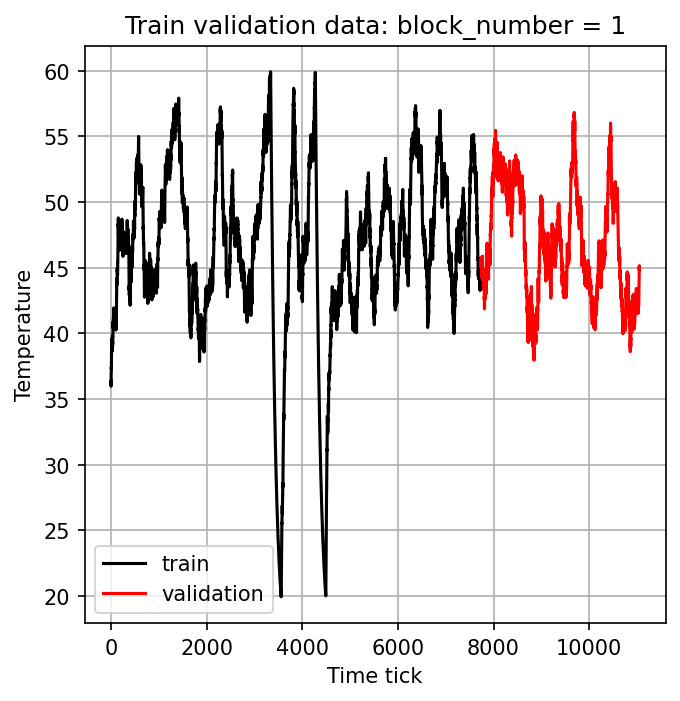

In [21]:
from plotting import plot_train_val_data

plot_train_val_data(heat_data=heat_data, train_size=train_size, block_number=1)

## Построение модели

GRU-модель:

In [22]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, device):
        super(GRU, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = device

        # GRU layer
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)

        # Output layers
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.to(device)

        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)

        # Forward propagate GRU
        out, _ = self.gru(x, h0)

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])

        return out

LSTM-модель:

In [23]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, device):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = device

        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # Output layers
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.to(device)

        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])

        return out

## Тренировка модели

In [24]:
from plotting import plot_losses
from training import calculate_test_loss, train

In [25]:
# Размерность входа модели
input_size = heat_data.shape[1]

# Размерность вектора скрытого состояния (подобрала Optuna)
hidden_size = 70 #295

# Размерность выхода модели
output_size = heat_data.shape[1] - 2

# Число слоев рекуррентной модели (подобрала Optuna)
num_layers = 3 #3

# Число эпох обучения
num_epochs = 30

# Частота отображения графика обучения модели
epoch_freq = 1

Создание модели, оптимизатора, шедуллера:

In [26]:
model = GRU(input_size, hidden_size, num_layers, output_size, device).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

criterion = nn.MSELoss() # функция потерь, можно выбрать абсолютную ошибку

scheduler = ReduceLROnPlateau(optimizer, 'min', patience=1, threshold=1e-4,
                              eps=1e-8, verbose=False)

Запуск обучения:

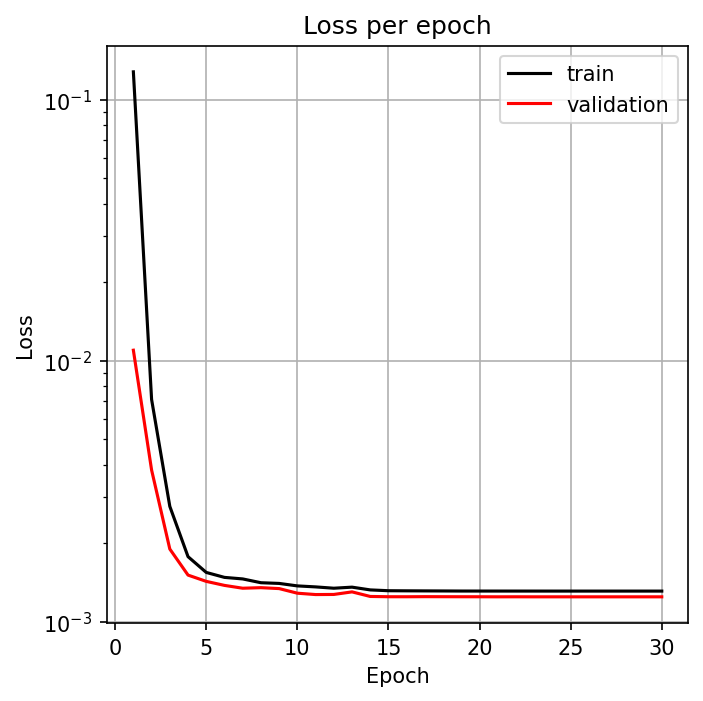

In [28]:
train(model=model, criterion=criterion, optimizer=optimizer, scheduler=scheduler,
      train_loader=train_loader, val_loader=val_loader,
      num_epochs=num_epochs, epoch_freq=epoch_freq,
      plot_progress=True, print_progress=False, trial=None)

In [57]:
PATH = '/content/rnn_state'
torch.save(model.state_dict(), PATH)

## Графическая валидация модели

### **Одношаговое предсказание**

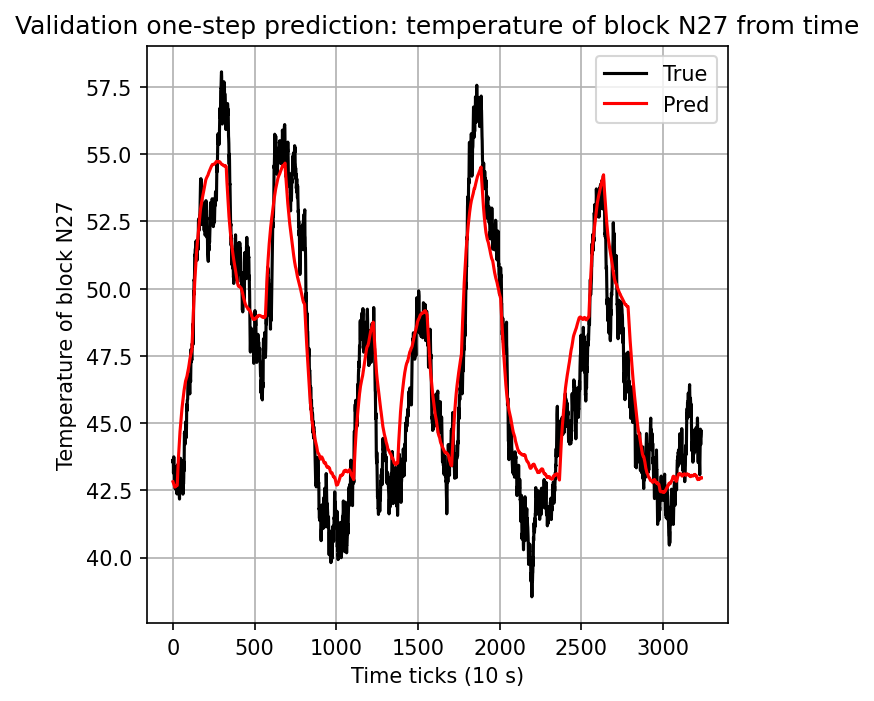

In [30]:
from onestep_prediction import plot_prediction_onestep

plot_prediction_onestep(model, test_dataset=val_dataset, block_number=27)

### **Рекуррентное предсказание**

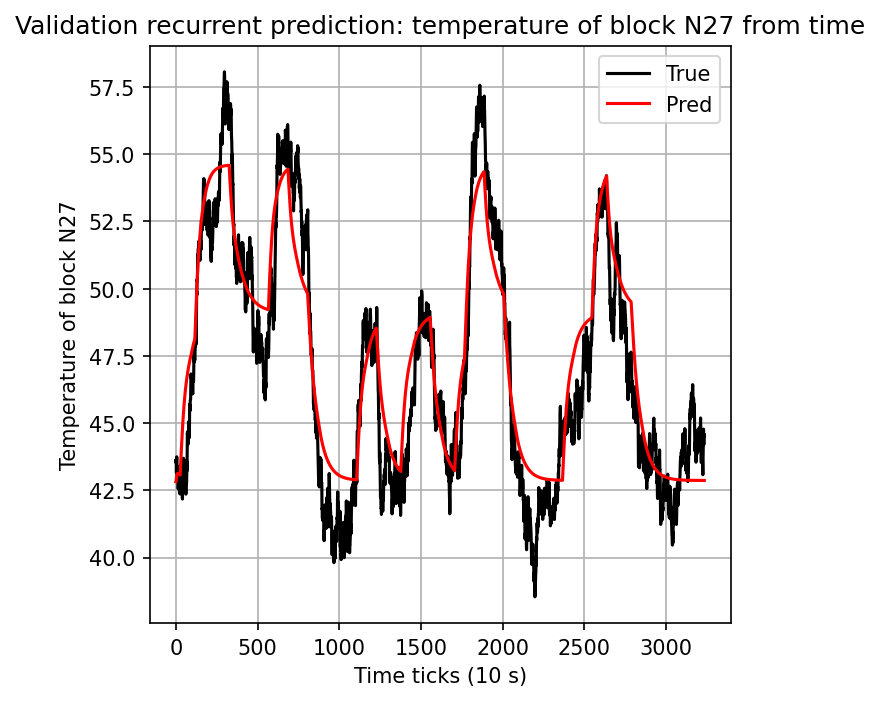

In [31]:
from recurrent_prediction import plot_prediction_recurrent

plot_prediction_recurrent(model, test_dataset=val_dataset, block_number=27, mode='Validation')

## Тестирование модели на другом датасете

In [37]:
filename = '288x10_test.csv'

In [38]:
column_names_maper = {}
column_names_maper[0] = 'time'
column_names_maper[1] = 'mode'
for i in range(2, 290):
    column_names_maper[i] = i - 1

In [40]:
%cd /content
heat_data_test = pd.read_csv(filename, sep='\t', header=None).rename(column_names_maper, axis=1)
heat_data_test = heat_data_test.drop(columns=290)
heat_data_test = pd.concat([heat_data_test.drop(columns='mode'), pd.get_dummies(heat_data_test['mode'], prefix='mode')], axis=1)
heat_data_test = heat_data_test.drop(columns=['mode_1', 'time'])

/content


In [41]:
heat_data_test.sample(1)

,1,2,3,4,5,6,7,8,9,10,...,281,282,283,284,285,286,287,288,mode_2,mode_3
8712,45.613,44.53,48.199,45.38,45.475,47.79,49.866,45.996,45.881,45.649,...,43.96,45.934,45.358,46.734,47.219,47.91,45.139,50.004,1,0


In [42]:
heat_data_test.shape

(9000, 290)

Оформляем тестовую выборку:

In [43]:
full_dataset = Heat_Sequence_Dataset(heat_data_test.copy())

### **Одношаговое предсказание**

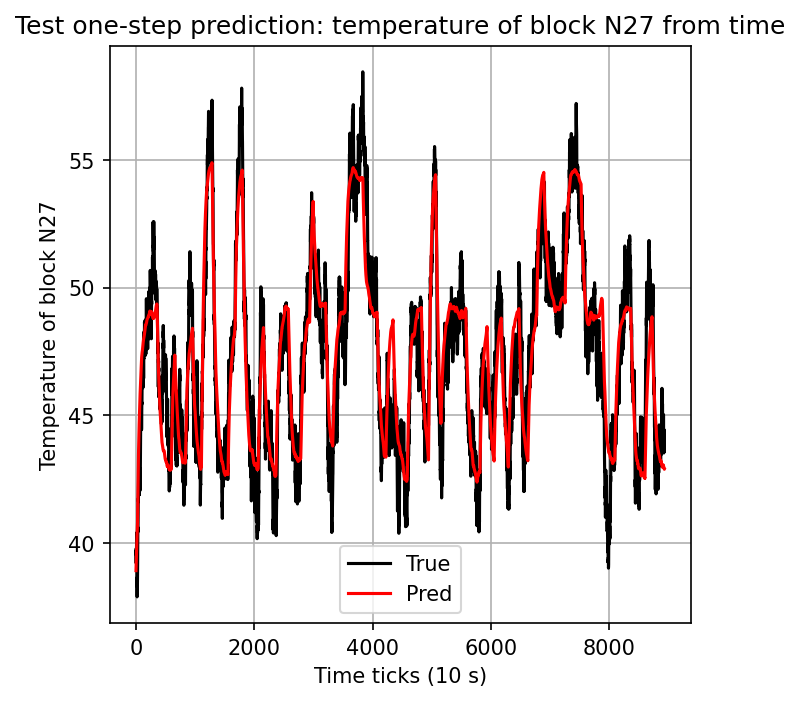

In [44]:
plot_prediction_onestep(model, test_dataset=full_dataset, block_number=27, mode='Test')

### **Рекуррентное предсказание**

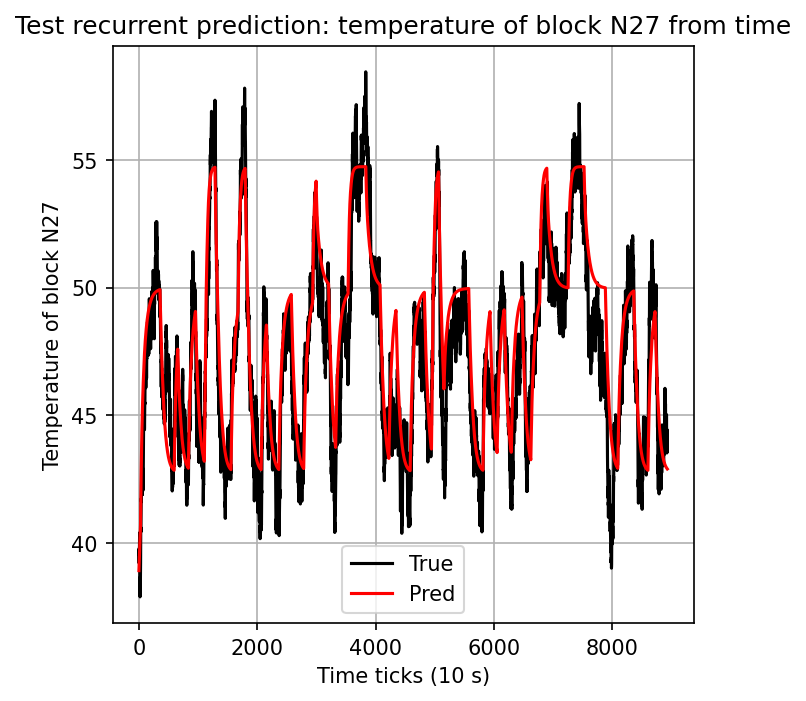

In [45]:
plot_prediction_recurrent(model, test_dataset=full_dataset, block_number=27, mode='Test')

## Подбор гиперпараметров: `optuna` (для подбора нужен компьютер с мощным железом)

In [ ]:
def objective(trial):
    """Define the objective function"""

    params = {
        'hidden_size': trial.suggest_int('hidden_size', low=16, high=512),
        'num_layers': trial.suggest_int('num_layers', low=1, high=5),
        'seq_len': trial.suggest_int('seq_len', low=16, high=256, step=16),
        'loss_function': trial.suggest_categorical('loss_function', ['mse', 'l1'])
    }
    # Fixed params
    num_epochs = 15
    input_size = heat_data.shape[1]
    output_size = heat_data.shape[1] - 2

    train_size = 0.7
    batch_size = 512

    # Getting dataset with specified `seq_len`
    train_data = heat_data.iloc[: int(len(heat_data) * train_size), :].copy()
    test_data = heat_data.iloc[int(len(heat_data) * train_size) :, :].copy()

    train_dataset = Heat_Sequence_Dataset(heat_data=train_data, seq_len=params['seq_len'])
    test_dataset = Heat_Sequence_Dataset(heat_data=test_data, seq_len=params['seq_len'])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

    # Fit the model
    model = GRU(input_size, params['hidden_size'], params['num_layers'], output_size, device).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    if params['loss_function'] == 'mse':
        criterion = nn.MSELoss()
    if params['loss_function'] == 'l1':
        criterion = nn.L1Loss()

    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, threshold=1e-7, eps=1e-12)

    train(model=model, criterion=criterion, optimizer=optimizer, scheduler=scheduler,
          train_loader=train_loader, test_loader=test_loader, num_epochs=num_epochs, epoch_freq=5,
          plot_progress=False, print_progress=False, trial=trial)

    # Evaluate metrics
    criterion = nn.MSELoss()
    test_loss = calculate_test_loss(model, criterion, test_loader)
    test_loss /= len(test_loader.dataset)

    return test_loss

Нужно разкоментить код ниже чтобы начать подбор гиперпарметров

In [ ]:

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=200) # n_trials - количество итераций подбора

# pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
# complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

# print("Study statistics: ")
# print("  Number of finished trials: ", len(study.trials))
# print("  Number of pruned trials: ", len(pruned_trials))
# print("  Number of complete trials: ", len(complete_trials))

# print("Best trial:")
# trial = study.best_trial

# print("  Value: ", trial.value)

# print("  Params: ")
# for key, value in trial.params.items():
#     print("    {}: {}".format(key, value))

## Ошибка предсказания со временем (для каждого блока в отдельности)

In [49]:
def get_true_pred_recurrent_for_MSE_loss(model, test_dataset):
    seq, y = test_dataset[0]
    seq, y = seq.to(device), y.to(device)

    y_true = []
    y_pred = []

    y_true += [unscale_temperature(y)]
    prediction = model(seq.unsqueeze(dim=0)).squeeze(dim=0)
    y_pred += [unscale_temperature(prediction)]

    with torch.no_grad():
        for i in range(1, len(test_dataset)):
            x, y = test_dataset[i]
            x, y = x.to(device), y.to(device)

            y_true += [unscale_temperature(y)]
            x = x[-1,-2:]

            new_row = torch.cat((prediction, x)).unsqueeze(dim=0)
            seq = torch.cat((seq[1:, :], new_row), axis=0)

            prediction = model(seq.unsqueeze(dim=0)).squeeze(dim=0)

            y_pred += [unscale_temperature(prediction)]

    return torch.stack(y_true), torch.stack(y_pred)

In [50]:
def plot_prediction_error(model, test_dataset):
    y_true, y_pred = get_true_pred_recurrent_for_MSE_loss(model, test_dataset)
    SD = torch.sqrt(((y_true - y_pred) ** 2).sum(axis=1) / y_true.shape[1])
    plt.figure(figsize=(5, 5), dpi=150)
    plt.plot(np.arange(len(y_pred)), SD.detach().cpu().numpy(), label='SD', color='red')
    plt.ylabel('SD loss')
    plt.xlabel('Time ticks (10 s)')
    plt.title(f'SD of temperature over time')
    plt.legend()
    plt.grid()
    plt.show()

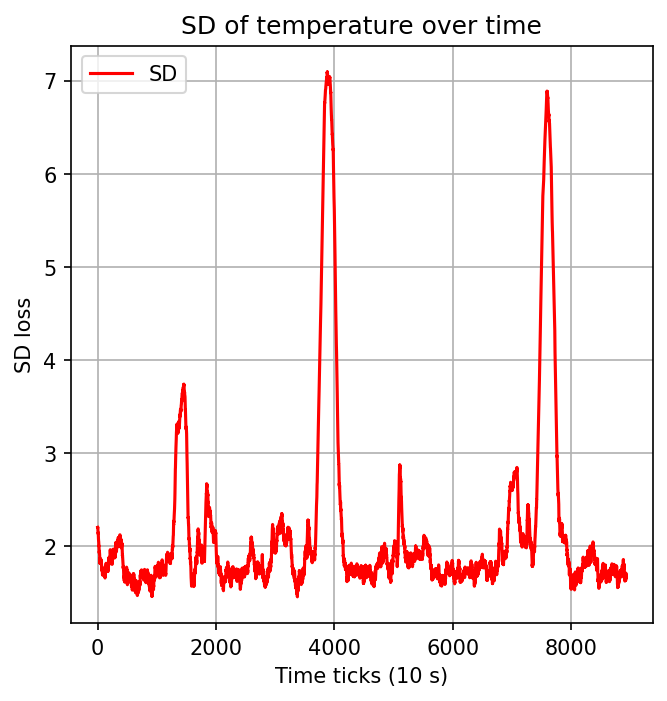

In [55]:
plot_prediction_error(model, full_dataset)